In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import tempfile
import gc

import matplotlib.pyplot as plt
import scanpy as sc
import scvi
import seaborn as sns
import torch
import numpy as np

In [3]:
alldata = sc.read_h5ad("431c764c-3d1f-4ba8-bcb0-b18de3966978.h5ad")

In [4]:
np.random.seed(42)
adata = alldata[np.random.choice(alldata.n_obs, 5000, replace=False), :].copy()
scvi.model.SCVI.setup_anndata(adata)

In [5]:
alldata=None

gc.collect()

1617

# Artificially create disease conditions by adding biases

## Amyotrophic Lateral Sclerosis (ALS) - Down-Regulated Genes in Cortex
- Gene expressions that are consistently down regulated such that signifies the disease

## Huntington's Disease - UP-Regulated Genes in Cortex (BA9)
- Gene expressions that are consistently up regulated such that signifies the disease

In [6]:
als_motor_cortex_downregulated_ensembl_ids = [
    # Energy Metabolism & Mitochondrial
    "ENSG00000014641",   # MDH1
    "ENSG00000172115",   # CYCS
    "ENSG00000189043",   # NDUFA4
    "ENSG00000152234",   # ATP5F1A (ATP5A1)
    
    # Cytoskeleton & Neurofilaments
    "ENSG00000104725",   # NEFL
    "ENSG00000100285",   # NEFH
    "ENSG00000104722",   # NEFM
    "ENSG00000137285",   # TUBB2A
    "ENSG00000176014",   # TUBB6
    
    # Ion Homeostasis & Calcium Binding
    "ENSG00000105409",   # ATP1A3
    "ENSG00000022355",   # GABRA1
    "ENSG00000176381",   # KCNC2
    "ENSG00000124140",   # SLC12A5
    "ENSG00000100362",   # PVALB
    "ENSG00000171862",   # NRGN
    "ENSG00000183134",   # PCP4
    "ENSG00000188127",   # RCAN2
    
    # Synaptic Vesicle & Neurotransmission
    "ENSG00000114573",   # ATP6V1A
    "ENSG00000073969",   # NSF
    "ENSG00000132639",   # SNAP25
    "ENSG00000103229",   # SYT13
    "ENSG00000089199",   # CHGB
    "ENSG00000166922",   # SCG5
    "ENSG00000175426",   # PCSK1
    
    # Protein Modification & Turnover
    "ENSG00000154277",   # UCHL1
    
    # Neuronal Maintenance & Signaling
    "ENSG00000112186",   # CAP2
    "ENSG00000171617",   # ENC1
    "ENSG00000213190",   # MLLT11
    "ENSG00000118785",   # OLFM1
    "ENSG00000163032",   # VSNL1
    "ENSG00000133169",   # BEX1
    "ENSG00000128656",   # CHN1
    "ENSG00000139970",   # RTN1
    "ENSG00000115310",   # RTN4
    "ENSG00000156642",   # NPTN
    "ENSG00000120738",   # EGR1
    
    # Other
    "ENSG00000156976",   # EIF4A2
    "ENSG00000203780",   # NAP1L5
    "ENSG00000087460",   # GNAS
    "ENSG00000185808",   # PNMA2
    "ENSG00000101811"    # YWHAH
]

In [7]:
huntington_disease_upregulated_ensembl_ids = [
    # Top High DES Score Genes (Most Abundant & Significant)
    "ENSG00000131095",   # GFAP (Glial fibrillary acidic protein) - Astrocyte marker
    "ENSG00000197971",   # MBP (Myelin basic protein) - Oligodendrocyte marker
    "ENSG00000120885",   # CLU (Clusterin)
    "ENSG00000135821",   # GLUL (Glutamate-ammonia ligase)
    "ENSG00000075886",   # TUBB4A (Tubulin beta-4A)
    "ENSG00000171885",   # AQP4 (Aquaporin 4)
    "ENSG00000111674",   # ENO2 (Enolase 2)
    "ENSG00000166033",   # AHNAK (AHNAK nucleoprotein)
    "ENSG00000163191",   # S100B (S100 calcium binding protein B)
    
    # HOX Genes (Developmental - 24 out of 39 HOX genes are DE)
    "ENSG00000170689",   # HOXB9
    "ENSG00000180806",   # HOXC10
    "ENSG00000078399",   # HOXA9
    "ENSG00000159184",   # HOXB13
    "ENSG00000128713",   # HOXD13
    "ENSG00000120075",   # HOXA10
    "ENSG00000253293",   # HOXB8
    "ENSG00000170178",   # HOXC9
    "ENSG00000122592",   # HOXA7
    "ENSG00000253293",   # HOXB7
    "ENSG00000120076",   # HOXA11
    "ENSG00000106004",   # HOXD10
    "ENSG00000253364",   # HOXC11
    "ENSG00000120084",   # HOXA13
    "ENSG00000198353",   # HOXB6
    "ENSG00000170166",   # HOXD11
    "ENSG00000005073",   # HOXA6
    "ENSG00000253449",   # HOXB5
    "ENSG00000128652",   # HOXD12
    "ENSG00000257570",   # HOXC13
    "ENSG00000173706",   # HOXD9
    "ENSG00000253522",   # HOXB4
    "ENSG00000106011",   # HOXD8
    "ENSG00000122691",   # TWIST1
    "ENSG00000140836",   # ZFPM2
    
    # NFkB Family & Inflammatory Response
    "ENSG00000109320",   # NFKB1 (log2 FC: 0.32)
    "ENSG00000077150",   # NFKB2 (log2 FC: 0.73)
    "ENSG00000173039",   # RELA (log2 FC: 0.63)
    "ENSG00000125952",   # RELB (log2 FC: -0.56, but mentioned as DE)
    "ENSG00000100906",   # NFKBIA
    "ENSG00000101017",   # CD40
    
    # Interleukin Receptors (15 upregulated)
    "ENSG00000056736",   # IL17RB
    "ENSG00000179639",   # IL13RA1
    "ENSG00000077238",   # IL4R
    "ENSG00000115594",   # IL1R1
    "ENSG00000174564",   # IL2RG
    "ENSG00000110324",   # IL10RA
    "ENSG00000112116",   # IL18RAP
    "ENSG00000115604",   # IL18R1
    "ENSG00000065135",   # IL15RA
    "ENSG00000186810",   # IL9R
    
    # Calpain Family
    "ENSG00000162909",   # CAPN2 (upregulated)
    "ENSG00000142507",   # CAPN7 (upregulated)
    
    # Calmodulin-related (mostly downregulated except CALML4)
    "ENSG00000178363",   # CALML4 (log2 FC: 0.42, upregulated)
    
    # Metallothioneins (nearly all MT1 subtypes are DE and upregulated)
    "ENSG00000169802",   # MT1A
    "ENSG00000125148",   # MT1E
    "ENSG00000168300",   # MT1F
    "ENSG00000125148",   # MT1G
    "ENSG00000179247",   # MT1H
    "ENSG00000125144",   # MT1M
    "ENSG00000187193",   # MT1X
    "ENSG00000125148",   # MT2A
    
    # Additional Immune/Inflammatory Markers
    "ENSG00000163739",   # CXCL1
    "ENSG00000169429",   # CXCL8 (IL8)
    "ENSG00000145826",   # IL15
    "ENSG00000115009",   # IL18
    "ENSG00000115008",   # IL9
    
    # Astrocyte & Glial Markers
    "ENSG00000108846",   # ABCC1
    "ENSG00000125149",   # GFRA1
    "ENSG00000118785",   # SPP1
    "ENSG00000132688",   # NES (Nestin)
    
    # Other Significant Upregulated Genes
    "ENSG00000143217",   # PITX1 (paired-like homeodomain)
    "ENSG00000149809",   # TM4SF1
    "ENSG00000163586",   # SCRG1
    "ENSG00000118785",   # OLFM1
    "ENSG00000162426",   # SLC38A2
    "ENSG00000168209",   # DDIT4
    "ENSG00000142867",   # TP53INP2
    "ENSG00000168209",   # GJA1 (Gap junction protein alpha 1)
    "ENSG00000157103",   # ADAMTS9
    "ENSG00000177575",   # CD163
]

In [8]:
def make_biased_adata(adata_in, gene_list, effect="up", fold_range=(1.9, 2.1), fraction_cells=0.95, noise_scale=0.02):
    """
    Return a new AnnData with multiplicative bias applied on layer 'counts'.
    - effect: 'up'|'down'|'mixed'
    - fraction_cells: fraction of cells in which to apply the bias (simulate incomplete penetrance)
    - fold_range: uniform [low, high] per gene per cell multiplicative factor
    """
    ad = adata_in.copy()
    # Work on counts layer (preserve shapes)
    if "counts" not in ad.layers:
        raise KeyError("adata must have 'counts' layer")
    counts = ad.layers["counts"].copy()
    if not isinstance(counts, np.ndarray):
        counts = counts.toarray()

    gene_idx = [ad.var_names.get_loc(g) for g in gene_list]
    n_cells = counts.shape[0]
    n_aff = max(1, int(np.ceil(n_cells * fraction_cells)))
    affected_cells = np.random.choice(n_cells, size=n_aff, replace=False)

    for i in affected_cells:
        per_cell_folds = np.random.uniform(fold_range[0], fold_range[1], size=len(gene_idx))
        for j, gi in enumerate(gene_idx):
            if effect == "up":
                counts[i, gi] = counts[i, gi] * per_cell_folds[j]
            elif effect == "down":
                counts[i, gi] = counts[i, gi] / per_cell_folds[j]
            elif effect == "mixed":
                if np.random.rand() < 0.5:
                    counts[i, gi] = counts[i, gi] * per_cell_folds[j]
                else:
                    counts[i, gi] = counts[i, gi] / per_cell_folds[j]
            else:
                raise ValueError("Unknown effect")
        # mild gaussian noise across all genes to avoid identical copies
        noise = np.random.normal(loc=0.0, scale=noise_scale * (counts[i].mean() + 1e-8), size=counts.shape[1])
        counts[i, :] = np.clip(counts[i, :] + noise, a_min=0.0, a_max=None)

    ad.layers["counts"] = counts

    ad.X = counts.copy()
    return ad

    

# Artificial disease condition biomarker
- Disease A is down regulated gene expressions of ALS
- Disease B is up regulated gene expressions in Huttington disease

In [9]:
adata.layers["counts"] = adata.X.copy()

In [10]:
genes_order = list(adata.var_names)
dA_genes = [i for i in als_motor_cortex_downregulated_ensembl_ids if i in genes_order]
dB_genes = [j for j in huntington_disease_upregulated_ensembl_ids if j in genes_order]
print("DiseaseA genes (count):", len(dA_genes)," out of ALS ", len(als_motor_cortex_downregulated_ensembl_ids), " genes.")
print("DiseaseB genes (count):", len(dB_genes), " out of Huttington ", len(huntington_disease_upregulated_ensembl_ids), " genes.")

als_motor_cortex_downregulated_ensembl_ids = None
huntington_disease_upregulated_ensembl_ids = None
genes_order = None

DiseaseA genes (count): 38  out of ALS  41  genes.
DiseaseB genes (count): 68  out of Huttington  80  genes.


In [11]:
adata_A = make_biased_adata(adata, dA_genes, effect="down", fold_range=(5.0, 10.0), fraction_cells=0.95, noise_scale=0.02)
sc.pp.normalize_total(adata_A, target_sum=1e4)
sc.pp.log1p(adata_A)


adata_B = make_biased_adata(adata, dB_genes, effect="up", fold_range=(5.0, 10.0), fraction_cells=0.9, noise_scale=0.02)
sc.pp.normalize_total(adata_B, target_sum=1e4)
sc.pp.log1p(adata_B)


In [12]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

adata.raw = adata


adata.X.shape

(5000, 29651)

In [13]:
adata.obs["synthetic_label"] = "Normal"
adata_A.obs["synthetic_label"] = "DiseaseA"
adata_B.obs["synthetic_label"] = "DiseaseB"

In [14]:
import anndata as ad
adata_combined = ad.concat([adata, adata_A, adata_B], join="outer", label="source", keys=["Normal", "DiseaseA", "DiseaseB"])

In [15]:
adata_combined.X.shape

(15000, 29651)

In [16]:
adata = None
adata_A = None
adata_B = None

gc.collect()

975

## Split the data into train, val and test

In [17]:
from sklearn.model_selection import train_test_split

indices = np.arange(adata_combined.n_obs)
labels = adata_combined.obs["synthetic_label"].values

# First, split out the test set (30%)
train_idx, test_idx = train_test_split(indices, test_size=0.3, random_state=42, shuffle=True, stratify=labels)

# Create AnnData subsets
adata_train = adata_combined[train_idx].copy()
adata_test = adata_combined[test_idx].copy()

# Check sizes
print(adata_train.n_obs, adata_test.n_obs)

9450 1050 4500


In [18]:
#adata_combined = None

In [19]:
# Force a full garbage collection
gc.collect()

714

# Train from the combined data unsupervised

In [20]:
adata_train.layers["counts"]

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 119723191 stored elements and shape (9450, 29651)>

In [21]:
scvi.model.LinearSCVI.setup_anndata(
    adata_train,
    layer="counts"  # singular, must match your AnnData layer
)

In [28]:
model = scvi.model.LinearSCVI(adata_train, n_latent=36)
model.train(max_epochs=200, plan_kwargs={"lr": 3e-3}, check_val_every_n_epoch=10 )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/200 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


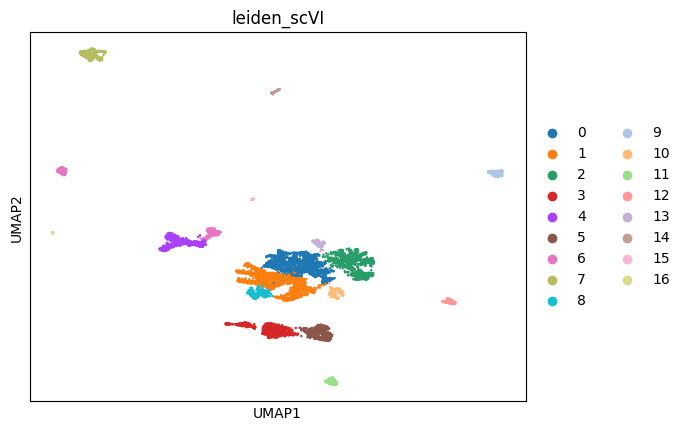

In [29]:
Z_hat = model.get_latent_representation()
for i, z in enumerate(Z_hat.T):
    adata_train.obs[f"Z_{i}"] = z
loadings = model.get_loadings()
loadings.head()

SCVI_LATENT_KEY = "X_scVI"
SCVI_CLUSTERS_KEY = "leiden_scVI"

adata_train.obsm[SCVI_LATENT_KEY] = Z_hat
sc.pp.neighbors(adata_train, use_rep=SCVI_LATENT_KEY, n_neighbors=30)
sc.tl.umap(adata_train, min_dist=0.3)
sc.tl.leiden(adata_train, key_added=SCVI_CLUSTERS_KEY, resolution=0.4)

sc.pl.umap(adata_train, color=[SCVI_CLUSTERS_KEY])

<Axes: xlabel='epoch'>

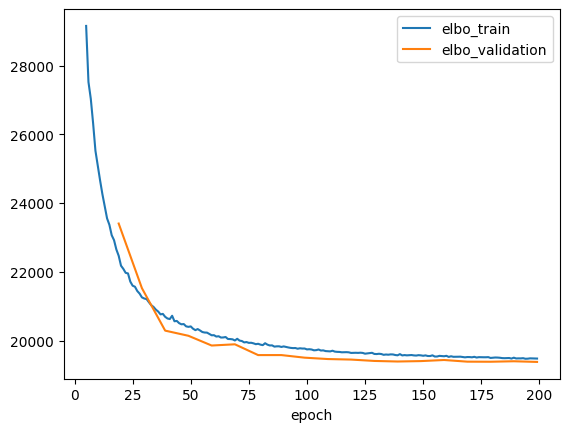

In [30]:
train_elbo = model.history["elbo_train"][5:]
test_elbo = model.history["elbo_validation"][1:]

ax = train_elbo.plot()
test_elbo.plot(ax=ax)

In [31]:
model.save("LDVAE-36dim.pt")

# Supervised Classifier using the latent representation of Normal (source) and Synthetic (Disease A, Disease B)

In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    balanced_accuracy_score, adjusted_rand_score
)

## Train/test split (stratified already) ---

In [35]:
np.random.seed(42)

latent_train = model.get_latent_representation(adata_train)
latent_test = model.get_latent_representation(adata_test)

latent_train.shape, latent_val.shape, latent_test.shape

((9450, 36), (1050, 36), (4500, 36))

In [48]:
# Put latent in adata_combined.obsm for later use
# adata_combined.obsm["X_latent"] = latent

# Prepare X,y for classification ---
label_series = adata_train.obs["synthetic_label"].astype(str)
# Map labels to ints (keeps mapping stable)
label_to_int = {lab: i for i, lab in enumerate(label_series.cat.categories)} if pd.api.types.is_categorical_dtype(label_series) else {lab: i for i, lab in enumerate(label_series.unique())}

# For safety, create sorted unique labels
unique_labels = np.unique(label_series)
label_to_int = {lab: i for i, lab in enumerate(unique_labels)}
print("Label mapping:", label_to_int)

X_train, y_train = latent_train, np.vectorize(label_to_int.get)(adata_train.obs["synthetic_label"].values)

X_train.shape, y_train.shape

Label mapping: {'DiseaseA': 0, 'DiseaseB': 1, 'Normal': 2}


((9450, 36), (9450,))

In [49]:
np.sum(y_train == 0), np.sum(y_train == 1),np.sum(y_train == 2)

(np.int64(3150), np.int64(3150), np.int64(3150))

In [50]:
X_test, y_test = latent_test, np.vectorize(label_to_int.get)(adata_test.obs["synthetic_label"].values)

X_test.shape, y_test.shape

((4500, 36), (4500,))

In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np


train_losses = []
val_losses = []
val_accs = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Prepare data ---
X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_t  = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_t  = torch.tensor(y_test, dtype=torch.long).to(device)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds  = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False)

# --- Define MLP with Softmax Output ---
class MLP_LDVAE(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128,64,32,16,8,4], num_classes=3, dropout=0.1):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = h
        layers.append(nn.Linear(prev_dim, num_classes))
        self.features = nn.Sequential(*layers)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        logits = self.features(x)
        probs = self.softmax(logits)  # explicitly output probabilities
        return probs

# --- Instantiate model ---
input_dim = X_train.shape[1] 
mlp = MLP_LDVAE(input_dim=input_dim).to(device)

# --- Training setup ---
criterion = nn.CrossEntropyLoss()  # still uses logits, so we'll feed in pre-softmax outputs
optimizer = optim.Adam(mlp.parameters(), lr=1e-4, weight_decay=1e-2)
num_epochs = 1000
patience = 50

best_val_acc = 0.0
epochs_no_improve = 0
best_state = None

# --- Training loop ---
for epoch in range(num_epochs):
    mlp.train()
    total_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        logits = mlp.features(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    avg_loss = total_loss / len(train_loader.dataset)

    # Validation
    mlp.eval()
    val_loss = 0.0
    preds, targets = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            probs = mlp(xb)
            loss_val = criterion(probs, yb)
            val_loss += loss_val.item() * xb.size(0)
            preds.extend(torch.argmax(probs, dim=1).cpu().numpy())
            targets.extend(yb.cpu().numpy())
    avg_val_loss = val_loss / len(test_loader.dataset)
    acc = accuracy_score(targets, preds)

    # In-place print
    print(f"\rEpoch [{epoch+1:02d}/{num_epochs}] | "
          f"Train Loss: {avg_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {acc:.4f}", end='')

    # --- Early stopping ---
    if acc > best_val_acc:
        best_val_acc = acc
        best_state = mlp.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print()
            print("Early stopping triggered.")
            break

# --- Load best model ---
if best_state:
    mlp.load_state_dict(best_state)

# --- Final evaluation ---
mlp.eval()
with torch.no_grad():
    all_probs = []
    all_preds = []
    all_targets = []
    for xb, yb in test_loader:
        probs = mlp(xb)
        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(torch.argmax(probs, dim=1).cpu().numpy())
        all_targets.extend(yb.cpu().numpy())

print("\nClassification report:")
print(classification_report(all_targets, all_preds, digits=3))
print("Confusion matrix:\n", confusion_matrix(all_targets, all_preds))

# --- Example of inspecting softmax probabilities ---
example_probs = all_probs[:5]
print("\nExample predicted probabilities:\n", np.round(example_probs, 3))


Epoch [113/1000] | Train Loss: 0.2823 | Val Loss: 0.6679 | Val Acc: 0.9127
Early stopping triggered.

Classification report:
              precision    recall  f1-score   support

           0      0.976     0.936     0.956      1500
           1      0.946     0.863     0.902      1500
           2      0.832     0.939     0.882      1500

    accuracy                          0.913      4500
   macro avg      0.918     0.913     0.913      4500
weighted avg      0.918     0.913     0.913      4500

Confusion matrix:
 [[1404    6   90]
 [  11 1294  195]
 [  23   68 1409]]

Example predicted probabilities:
 [[0.975 0.012 0.013]
 [0.016 0.954 0.03 ]
 [0.017 0.952 0.031]
 [0.753 0.095 0.152]
 [0.041 0.082 0.877]]


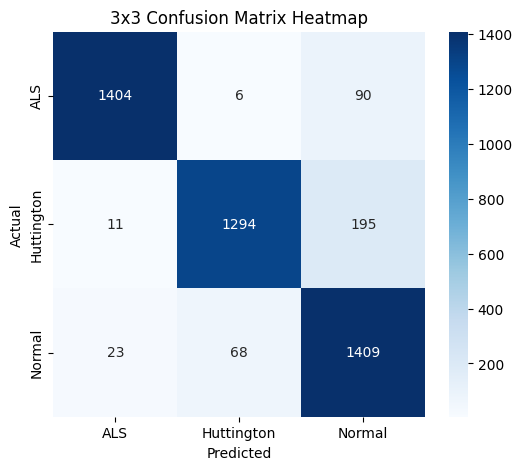

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Example 3x3 confusion matrix
cm = confusion_matrix(all_targets, all_preds)

# Define class labels for your 3 classes
classes = ['ALS', 'Huttington', 'Normal']

# Plot heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('3x3 Confusion Matrix Heatmap')
plt.show()
